In [1]:
import pandas as pd
from datetime import datetime
import matplotlib
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np

In [2]:
from sklearn.metrics import mean_squared_error

In [3]:
import os
os.system("pip install holidays")
import holidays

In [4]:
#импорт модулей для формирования модели
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA

In [5]:
'''
Прочитайте базу my_BRENT2019.csv. Сделайте ее перерасчет (ресемплинг) в представление по неделям и 
перейдите к представлению ряда первыми разностями.
Добавьте первые разности по стоимости доллара и евро к рублю (недельные).

Постройте модель предсказания 1-й точки от текущей (h=1).
Сделайте вывод о поведении ошибки предсказания ряда в сравнении с прямым прогнозированием.
'''

'\nПрочитайте базу my_BRENT2019.csv. Сделайте ее перерасчет (ресемплинг) в представление по неделям и \nперейдите к представлению ряда первыми разностями.\nДобавьте первые разности по стоимости доллара и евро к рублю (недельные).\n\nПостройте модель предсказания 1-й точки от текущей (h=1).\nСделайте вывод о поведении ошибки предсказания ряда в сравнении с прямым прогнозированием.\n'

In [6]:
matplotlib.rcParams['figure.figsize'] =  [12.0, 8.0]

## Подготовка данных 1 (EDA)

In [7]:
path = 'C:/Users/user/Documents/mydocs/gb_timeseries/data/'

In [8]:
df = pd.read_csv(path + 'my_BRENT2019.csv')
df.head(5)

,Дата,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
0,2010-09-01,76.37,2010,9,1,3,244,35,2,0,0,0
1,2010-09-02,76.89,2010,9,2,3,245,35,3,0,0,0
2,2010-09-03,76.57,2010,9,3,3,246,35,4,0,0,0
3,2010-09-04,76.62,2010,9,4,3,247,35,5,0,0,0
4,2010-09-05,76.63,2010,9,5,3,248,35,6,0,1,0


In [9]:
df.tail()

,Дата,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
2662,2019-08-27,59.59,2019,8,27,3,239,35,1,0,0,0
2663,2019-08-28,59.84,2019,8,28,3,240,35,2,0,0,0
2664,2019-08-29,60.37,2019,8,29,3,241,35,3,0,0,0
2665,2019-08-30,59.19,2019,8,30,3,242,35,4,0,0,0
2666,2019-09-01,58.84,2019,9,1,3,244,35,6,0,1,0


In [10]:
df = df.rename(columns={'Дата': 'date', 'Значение': 'value'})

In [11]:
df.head()

,date,value,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
0,2010-09-01,76.37,2010,9,1,3,244,35,2,0,0,0
1,2010-09-02,76.89,2010,9,2,3,245,35,3,0,0,0
2,2010-09-03,76.57,2010,9,3,3,246,35,4,0,0,0
3,2010-09-04,76.62,2010,9,4,3,247,35,5,0,0,0
4,2010-09-05,76.63,2010,9,5,3,248,35,6,0,1,0


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2667 entries, 0 to 2666
Data columns (total 12 columns):
date               2667 non-null object
value              2667 non-null float64
year               2667 non-null int64
month              2667 non-null int64
dayofmonth         2667 non-null int64
quarter            2667 non-null int64
dayofyear          2667 non-null int64
weekofyear         2667 non-null int64
dayofweek          2667 non-null int64
is_holiday         2667 non-null int64
is_prev_holiday    2667 non-null int64
is_next_holiday    2667 non-null int64
dtypes: float64(1), int64(10), object(1)
memory usage: 250.2+ KB


In [13]:
#преобразуем колонку дат в формат дат pandas

df["date"] = df["date"].apply(pd.to_datetime)

In [14]:
#сделаем из даты индекс 
df = df.set_index('date')

In [15]:
#есть ли пропуски в значениях?

df.isnull().sum()

value              0
year               0
month              0
dayofmonth         0
quarter            0
dayofyear          0
weekofyear         0
dayofweek          0
is_holiday         0
is_prev_holiday    0
is_next_holiday    0
dtype: int64

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2667 entries, 2010-09-01 to 2019-09-01
Data columns (total 11 columns):
value              2667 non-null float64
year               2667 non-null int64
month              2667 non-null int64
dayofmonth         2667 non-null int64
quarter            2667 non-null int64
dayofyear          2667 non-null int64
weekofyear         2667 non-null int64
dayofweek          2667 non-null int64
is_holiday         2667 non-null int64
is_prev_holiday    2667 non-null int64
is_next_holiday    2667 non-null int64
dtypes: float64(1), int64(10)
memory usage: 250.0 KB


In [17]:
# добавим признак первые разности 
first_diff =np.array(df.iloc[1:,0].values - df.iloc[:-1,0].values).astype('float32') 
df['diff1'] = 0
df['diff1'] =  df['diff1'].astype('float') 
df['diff1'].values[1:] = first_diff

In [18]:
#Добавим первые разности по стоимости доллара и евро к рублю (недельные).

In [19]:
#скачает данные центробанка 
'https://www.cbr.ru/currency_base/dynamics/?UniDbQuery.Posted=True&UniDbQuery.mode=1&UniDbQuery.date_req1=&UniDbQuery.date_req2=&UniDbQuery.VAL_NM_RQ=R01235&UniDbQuery.From=01.09.2010&UniDbQuery.To=01.09.2019'
df_usd = pd.read_excel(path + 'RC_F01_09_2010_T01_09_2019_usd.xlsx')
df_euro = pd.read_excel(path + 'RC_F01_09_2010_T01_09_2019_euro.xlsx')

In [20]:
#добавим столбцы значений курса доллара и евро

In [21]:
dict_usd = {d['data']: d['curs'] for d in df_usd.to_dict(orient='records')}
dict_euro = {d['data']: d['curs'] for d in df_euro.to_dict(orient='records')}
df['usd'] = df.index.map(dict_usd)
df['euro'] = df.index.map(dict_euro)

In [22]:
#посмотрим, есть ли нулевые значения
df.isnull().sum()

value                0
year                 0
month                0
dayofmonth           0
quarter              0
dayofyear            0
weekofyear           0
dayofweek            0
is_holiday           0
is_prev_holiday      0
is_next_holiday      0
diff1                0
usd                909
euro               909
dtype: int64

In [23]:
#курсы вылают не считают на выходные, заменим их предыдущими значениями 
df = df.fillna(method='ffill')

In [24]:
# добавим признак первые разности по доллару
first_diff_usd =np.array(df.iloc[1:,12].values - df.iloc[:-1,12].values).astype('float32') 
df['diff1_usd'] = 0
df['diff1_usd'] =  df['diff1_usd'].astype('float') 
df['diff1_usd'].values[1:] = first_diff_usd

In [25]:
# добавим признак первые разности по евро
first_diff_euro =np.array(df.iloc[1:,13].values - df.iloc[:-1,13].values).astype('float32') 
df['diff1_euro'] = 0
df['diff1_euro'] =  df['diff1_euro'].astype('float') 
df['diff1_euro'].values[1:] = first_diff_euro

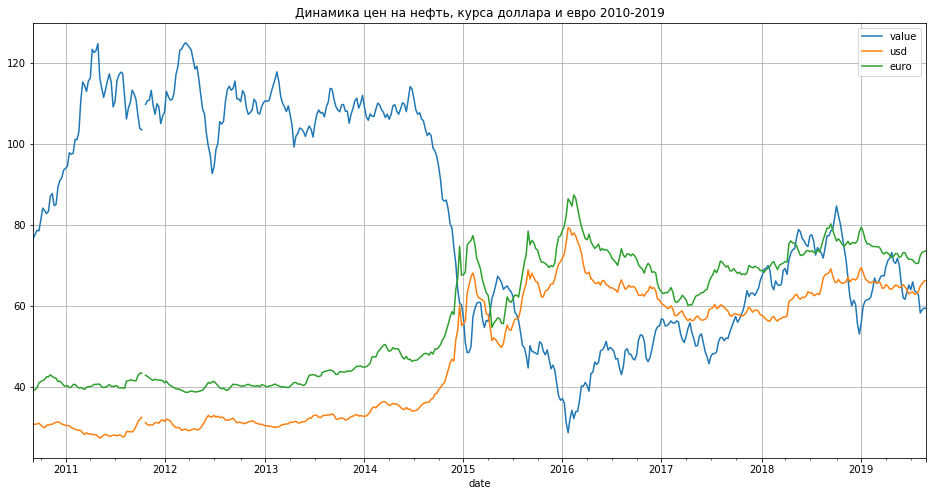

In [26]:
#посмотрим на динамику абсолютных значений курсов и стоимости нефти 
matplotlib.rcParams['figure.figsize'] =  [16.0, 8.0]
df['value'].resample("W").mean().plot()
df['usd'].resample("W").mean().plot()
df['euro'].resample("W").mean().plot()
plt.title('Динамика цен на нефть, курса доллара и евро 2010-2019')
plt.grid()
plt.legend()
plt.show()

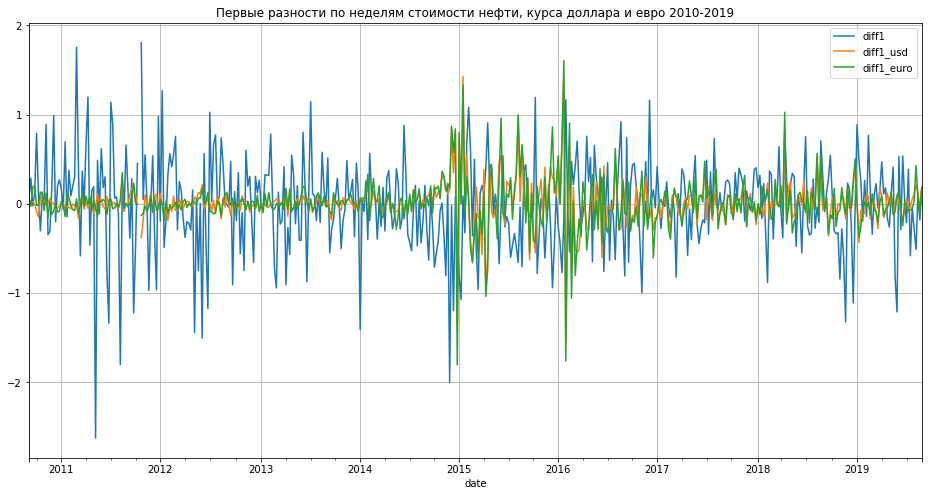

In [27]:
#перейдем к представлению по неделям по разностям 
matplotlib.rcParams['figure.figsize'] =  [16.0, 8.0]
df['diff1'].resample("W").mean().plot()
df['diff1_usd'].resample("W").mean().plot()
df['diff1_euro'].resample("W").mean().plot()
plt.title('Первые разности по неделям стоимости нефти, курса доллара и евро 2010-2019')
plt.grid()
plt.legend()
plt.show()

In [28]:
#подготовим данные для модели на основе еженедельного среза 
df_w = df.resample("W").mean()

## Разделим данные на тестовые и тренировочные во временных рядах


In [ ]:
строим x=D [:-1,:], y=[1:,0]

In [29]:
# сделаем функцию на основе даты
def split_data( data, split_date ):
    return data.loc[data.index.get_level_values('date') <= split_date].copy(), \
           data.loc[data.index.get_level_values('date') >  split_date].copy()

In [30]:
df_w.head()

,value,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday,diff1,usd,euro,diff1_usd,diff1_euro
date,,,,,,,,,,,,,,,,
2010-09-05,76.616000,2010.0,9.000000,3.000000,3.000000,246.000000,35.0,4.000000,0.000000,0.2,0.000000,0.052000,30.747440,39.233840,-0.034940,0.067560
2010-09-12,77.673333,2010.0,9.000000,8.500000,3.000000,251.500000,36.0,2.500000,0.166667,0.0,0.166667,0.288333,30.777050,39.302883,0.033583,-0.026467
2010-09-19,78.693333,2010.0,9.000000,15.666667,3.000000,258.666667,37.0,2.666667,0.000000,0.0,0.000000,-0.021667,30.844500,39.764250,0.021433,0.187483
2010-09-26,78.518333,2010.0,9.000000,22.666667,3.000000,265.666667,38.0,2.666667,0.000000,0.0,0.000000,0.118333,31.012233,40.967983,-0.003200,0.203567
2010-10-03,81.211667,2010.0,9.333333,19.666667,3.333333,272.666667,39.0,2.666667,0.000000,0.0,0.000000,0.791667,30.607417,41.345817,-0.081750,-0.016467


In [70]:
df_w = df_w.loc[~df_w['value'].isnull()]

In [71]:
train, test = split_data( df_w, '2017-08-27') # 2017-01-01

Построим модель предсказания 1-й точки от текущей (h=1)

In [72]:
h = 1

#Теперь выделим описание объекта и целевое свойство 

X_train = train.iloc[:-h, :]
y_train = train['diff1'].values[h:]
X_test = test.iloc[:-h, :]
y_test = test['diff1'].values[h:]

In [73]:
X_train.drop( columns = 'diff1', inplace = True )
X_test.drop( columns = 'diff1', inplace = True )

C:\Users\user\anaconda3\lib\site-packages\pandas\core\frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


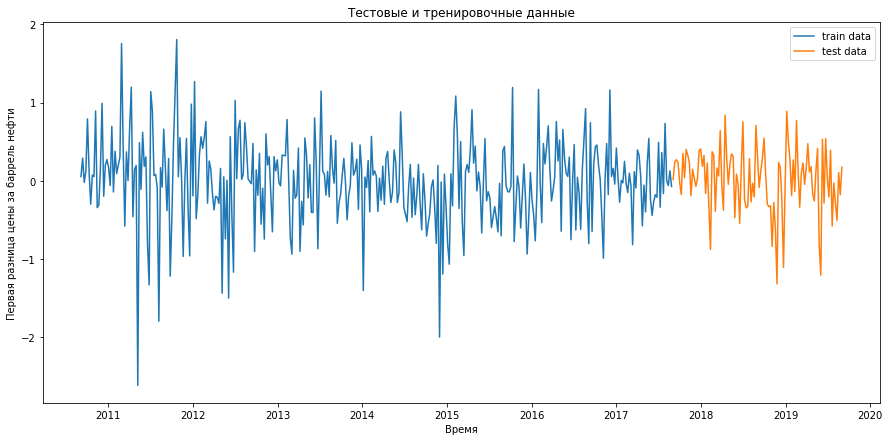

In [74]:
plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Первая разница цены за баррель нефти')
plt.plot(train.index.get_level_values('date'),train['diff1'], label='train data' )
plt.plot(test.index.get_level_values('date'),test['diff1'], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

## Строим модель 

In [75]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

Все модели возьмем в варианте параметров по умолчанию.

In [76]:
model_l = LinearRegression()
model_f = RandomForestRegressor(max_depth=5, random_state=0, n_estimators=100)
model_g = GradientBoostingRegressor(max_depth=5, random_state=0, n_estimators=100)

Запускаем модели

In [77]:
model_l.fit( X_train, y_train )
model_f.fit( X_train, y_train )
model_g.fit( X_train, y_train )

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=0, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [78]:
X_test_pred_l = model_l.predict(X_test)
X_test_pred_f = model_f.predict(X_test)
X_test_pred_g = model_g.predict(X_test)

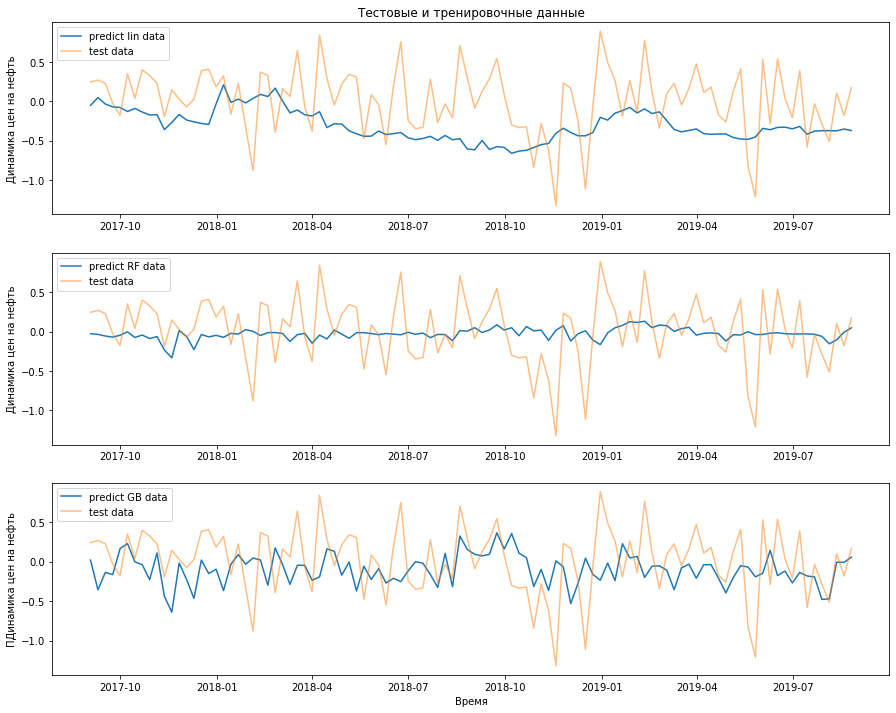

In [81]:

plt.figure( figsize=( 15, 12 ))
plt.subplot(3,1,1)

plt.ylabel('Динамика цен на нефть')
plt.plot(X_test.index.get_level_values('date'),X_test_pred_l, label='predict lin data' )
plt.plot(X_test.index.get_level_values('date'),y_test, label='test data', alpha = 0.5)
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.subplot(3,1,2)

plt.ylabel('Динамика цен на нефть')
plt.plot(X_test.index.get_level_values('date'),X_test_pred_f, label='predict RF data' )
plt.plot(X_test.index.get_level_values('date'),y_test, label='test data', alpha = 0.5)

plt.legend()
plt.subplot(3,1,3)
plt.xlabel('Время')
plt.ylabel('ПДинамика цен на нефть')
plt.plot(X_test.index.get_level_values('date'),X_test_pred_g, label='predict GB data' )
plt.plot(X_test.index.get_level_values('date'),y_test, label='test data', alpha = 0.5)

plt.legend()
plt.show()

**Средне Квадратичное Отклонение - Mean Square Error**

In [82]:
er_l = mean_squared_error(y_true=y_test, y_pred=X_test_pred_l) 
er_f = mean_squared_error(y_true=y_test, y_pred=X_test_pred_f) 
er_g = mean_squared_error(y_true=y_test, y_pred=X_test_pred_g)

print('ошибка линейной регрессии :  ', er_l,'\nошибка случайного леса  :  ', er_f,'\nошибка градиентного бустинга :  ', er_g)

ошибка линейной регрессии :   0.26982532660949266 
ошибка случайного леса  :   0.17844966773475246 
ошибка градиентного бустинга :   0.21437517064316153


**Это средняя абсолютная процентная ошибка (MAPE)**

Проверим другую оценку, которая соотносит размер промаха с абсолютным значением целевого сигнала. 

In [83]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [84]:
er_l = mean_absolute_percentage_error(y_true=y_test, y_pred=X_test_pred_l) 
er_f = mean_absolute_percentage_error(y_true=y_test, y_pred=X_test_pred_f) 
er_g = mean_absolute_percentage_error(y_true=y_test, y_pred=X_test_pred_g)

print('ошибка линейной регрессии :  ', er_l,'\nошибка случайного леса  :  ', er_f,'\nошибка градиентного бустинга :  ', er_g)

ошибка линейной регрессии :   230.7289098050565 
ошибка случайного леса  :   113.71503172698456 
ошибка градиентного бустинга :   158.5359267154156


**Вывод о поведении ошибки предсказания ряда в сравнении с прямым прогнозированием.**

Мы проверили три модели предсказания на 1 шаг и все показывают плохой результат на сэмплированных жанных за 1 неделю. Скорее всего необходимо добавить переменных и перейти период данных в 1 день. 